In [1]:
import os
import time
import torch
import random
import functions
import dataClass
import functions
import numpy as np
import numpy as np
import pandas as pd
import torch.nn as nn
from pesq import pesq
import torch.optim as optim
import matplotlib.pyplot as plt
from torchinfo import summary
import torchsummary
from torch.utils.data import DataLoader

### Data Import

In [2]:
filepath = "./data_details.csv"
df = functions.read_csv_data(filepath)
df = df.iloc[:2500]
print(df.shape)
df.head()

(2500, 17)


Unnamed: 0  mixed     near_end     far_end1     far_end2  \
0           0  1.wav  FAEM0_1.wav  MGJC0_4.wav  MJRK0_3.wav   
1           1  2.wav  FAEM0_1.wav  MMCC0_2.wav  MPRK0_1.wav   
2           2  3.wav  FAEM0_1.wav  FBAS0_4.wav  MSEM1_2.wav   
3           3  4.wav  FAEM0_1.wav  MTJG0_1.wav  MWAR0_3.wav   
4           4  5.wav  FAEM0_1.wav  FEEH0_3.wav  MRDS0_2.wav   

           mixed_path                near_end_path  \
0  ./data/mixed/1.wav  ./data/near_end/FAEM0_1.wav   
1  ./data/mixed/2.wav  ./data/near_end/FAEM0_1.wav   
2  ./data/mixed/3.wav  ./data/near_end/FAEM0_1.wav   
3  ./data/mixed/4.wav  ./data/near_end/FAEM0_1.wav   
4  ./data/mixed/5.wav  ./data/near_end/FAEM0_1.wav   

                far_end1_path               far_end2_path near_end_loc  \
0  ./data/far_end/MGJC0_4.wav  ./data/far_end/MJRK0_3.wav    [2, 4, 1]   
1  ./data/far_end/MMCC0_2.wav  ./data/far_end/MPRK0_1.wav    [9, 1, 3]   
2  ./data/far_end/FBAS0_4.wav  ./data/far_end/MSEM1_2.wav   [10, 2, 1]   
3  ./data/far_end/MTJG0_1.wav  ./data/far_end/MWAR0_3.wav    [9, 5, 3]   
4  ./data/far_end/FEEH0_3.wav  ./data/far_end/MRDS0_2.wav    [9, 4, 3]   

  far_end_loc1 far_end_loc2     mic_loc1     room_dim  sample_freq  \
0   [14, 7, 3]   [10, 1, 4]    [9, 7, 5]  [15, 10, 5]        16000   
1   [14, 5, 2]   [10, 5, 4]  [13, 10, 3]  [15, 10, 5]        16000   
2    [8, 6, 4]    [3, 2, 2]    [7, 5, 4]  [15, 10, 5]        16000   
3    [6, 3, 4]    [8, 9, 4]    [7, 6, 1]  [15, 10, 5]        16000   
4    [4, 7, 1]   [12, 2, 4]    [5, 1, 1]  [15, 10, 5]        16000   

   room_max_order  room_absorption  
0               3              0.2  
1               3              0.2  
2               3              0.2  
3               3              0.2  
4               3              0.2

In [3]:
mixed = df['mixed_path'].tolist()
far1 = df['far_end1_path'].tolist()
far2 = df['far_end2_path'].tolist()
near = df['near_end_path'].tolist()
print(len(near), len(far1), len(far2), len(mixed))

2500 2500 2500 2500


### CNN

In [ ]:
# Tanh seems to work best in hidden layers compared to LeakyReLU, ReLU, Sigmoid
# Last convolution layer without activation seems to work better

In [4]:
def train_CNN(model, train_loader, num_epochs=10, learning_rate=0.001, device="cuda", erle_arr=[], pesq_arr=[], max_frames=512):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0

        for mixed, far1, far2, near, near_phase in train_loader:
            combined_input = torch.cat((far1, far2, mixed), dim=1) # [batch_size, 3*257, 512]
            optimizer.zero_grad()
            
            outputs = model(combined_input)
            loss = criterion(outputs.squeeze(1), near)
            loss.backward()
            optimizer.step()
        
        near_phase = near_phase.cpu().numpy()
        near = near.cpu().numpy()
        outputs = outputs.detach().cpu().squeeze(1).numpy()
        erle_score = functions.compute_erle(near, outputs)
        near_wave = functions.to_wave(near[0], near_phase[0], write=0, filename="near")
        output_wave = functions.to_wave(outputs[0], near_phase[0], write=0, filename="output")
        pesq_score = pesq(16000, near_wave, output_wave)
        erle_arr.append(erle_score)
        pesq_arr.append(pesq_score)
        duration = functions.timeit(start_time)
        print(f"[Epoch {epoch+1:3d}/{num_epochs:2d}] Train Loss: {loss.item():.4f}, Duration: {duration}, ERLE Score: {erle_score:.2f}, PESQ Score: {pesq_score:.2f}")



##### CNN 1

In [2]:
class CNN1D(nn.Module):
    def __init__(self, input_channels=771, output_channels=257, kernel_size=5, padding=2, stride=1):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 256, kernel_size, stride, padding)
        self.act1 = nn.Tanh()
        self.dropout1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv1d(256, 256, kernel_size, stride, padding)
        self.act2 = nn.Tanh()
        self.dropout2 = nn.Dropout(p=0.2)
        self.conv3 = nn.Conv1d(256, 256, kernel_size, stride, padding)
        self.act3 = nn.Tanh()
        self.dropout3 = nn.Dropout(p=0.2)
        self.conv4 = nn.Conv1d(256, 256, kernel_size, stride, padding)
        self.act4 = nn.Tanh()
        self.dropout4 = nn.Dropout(p=0.2)
        self.conv5 = nn.Conv1d(256, output_channels, kernel_size, stride, padding)
        self.act5 = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.act1(self.conv1(x)))
        x = self.dropout2(self.act2(self.conv2(x)))
        x = self.dropout3(self.act3(self.conv3(x)))
        x = self.dropout4(self.act4(self.conv4(x)))
        x = self.conv5(x)
        return x

In [9]:
batch_size = 64
num_epochs = 30
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
model = CNN1D().to(device)
summary(model, (771, 512))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [257, 512]                --
├─Conv1d: 1-1                            [256, 512]                987,136
├─Tanh: 1-2                              [256, 512]                --
├─Dropout: 1-3                           [256, 512]                --
├─Conv1d: 1-4                            [256, 512]                327,936
├─Tanh: 1-5                              [256, 512]                --
├─Dropout: 1-6                           [256, 512]                --
├─Conv1d: 1-7                            [256, 512]                327,936
├─Tanh: 1-8                              [256, 512]                --
├─Dropout: 1-9                           [256, 512]                --
├─Conv1d: 1-10                           [256, 512]                327,936
├─Tanh: 1-11                             [256, 512]                --
├─Dropout: 1-12                          [256, 512]              

In [11]:
train_CNN(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/30] Train Loss: 0.0021, Duration: 38 seconds, ERLE Score: 2.32, PESQ Score: 1.04
[Epoch   2/30] Train Loss: 0.0029, Duration: 28 seconds, ERLE Score: 3.26, PESQ Score: 1.10
[Epoch   3/30] Train Loss: 0.0019, Duration: 28 seconds, ERLE Score: 3.56, PESQ Score: 1.11
[Epoch   4/30] Train Loss: 0.0016, Duration: 27 seconds, ERLE Score: 1.81, PESQ Score: 1.15
[Epoch   5/30] Train Loss: 0.0019, Duration: 27 seconds, ERLE Score: 5.92, PESQ Score: 1.13
[Epoch   6/30] Train Loss: 0.0009, Duration: 27 seconds, ERLE Score: 1.72, PESQ Score: 1.13
[Epoch   7/30] Train Loss: 0.0033, Duration: 27 seconds, ERLE Score: 1.75, PESQ Score: 1.24
[Epoch   8/30] Train Loss: 0.0020, Duration: 27 seconds, ERLE Score: 0.61, PESQ Score: 1.30
[Epoch   9/30] Train Loss: 0.0016, Duration: 27 seconds, ERLE Score: 0.46, PESQ Score: 1.25
[Epoch  10/30] Train Loss: 0.0024, Duration: 27 seconds, ERLE Score: 3.01, PESQ Score: 1.32
[Epoch  11/30] Train Loss: 0.0018, Duration: 27 seconds, ERLE Score: 1.77, PESQ 

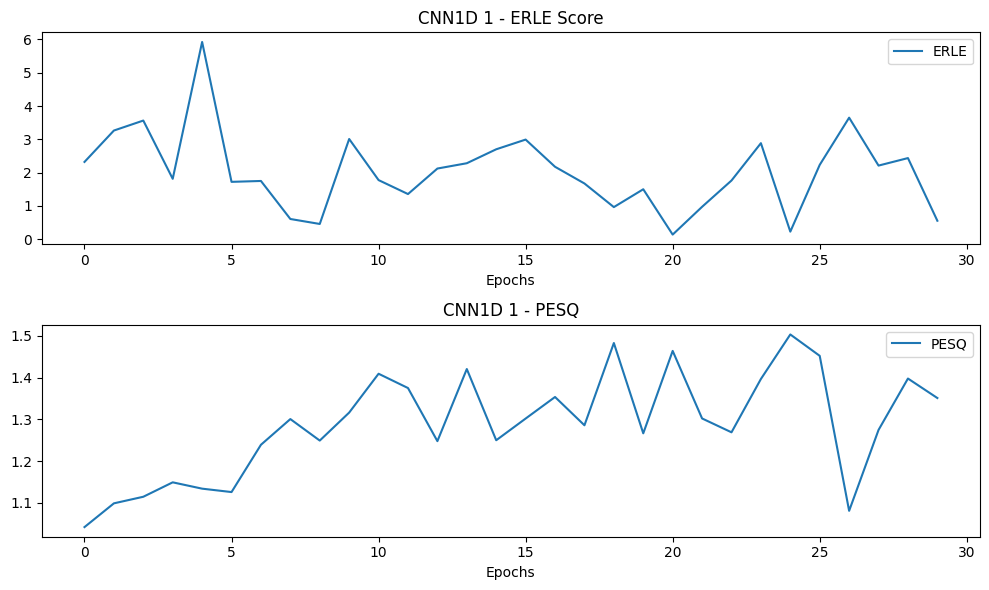

In [12]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("CNN1D 1 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("CNN1D 1 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
torch.save(model, "./models/CNN1D_1.pth")

In [3]:
model = torch.load("./models/CNN1D_1.pth")
model = model.to('cuda') 
model.eval()


CNN1D(
  (conv1): Conv1d(771, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (act1): Tanh()
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (act2): Tanh()
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (act3): Tanh()
  (dropout3): Dropout(p=0.2, inplace=False)
  (conv4): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (act4): Tanh()
  (dropout4): Dropout(p=0.2, inplace=False)
  (conv5): Conv1d(256, 257, kernel_size=(5,), stride=(1,), padding=(2,))
  (act5): Sigmoid()
)

In [4]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
combined_input = combined
combined_input.shape

torch.Size([771, 512])

In [5]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="CNN1D_1", n_fft=512, hop_length=256, sr=16000, write=1)

array([2.2764036e-05, 1.6602768e-05, 1.8724979e-05, ..., 1.2657621e-05,
       9.5734767e-06, 1.2214195e-05], dtype=float32)

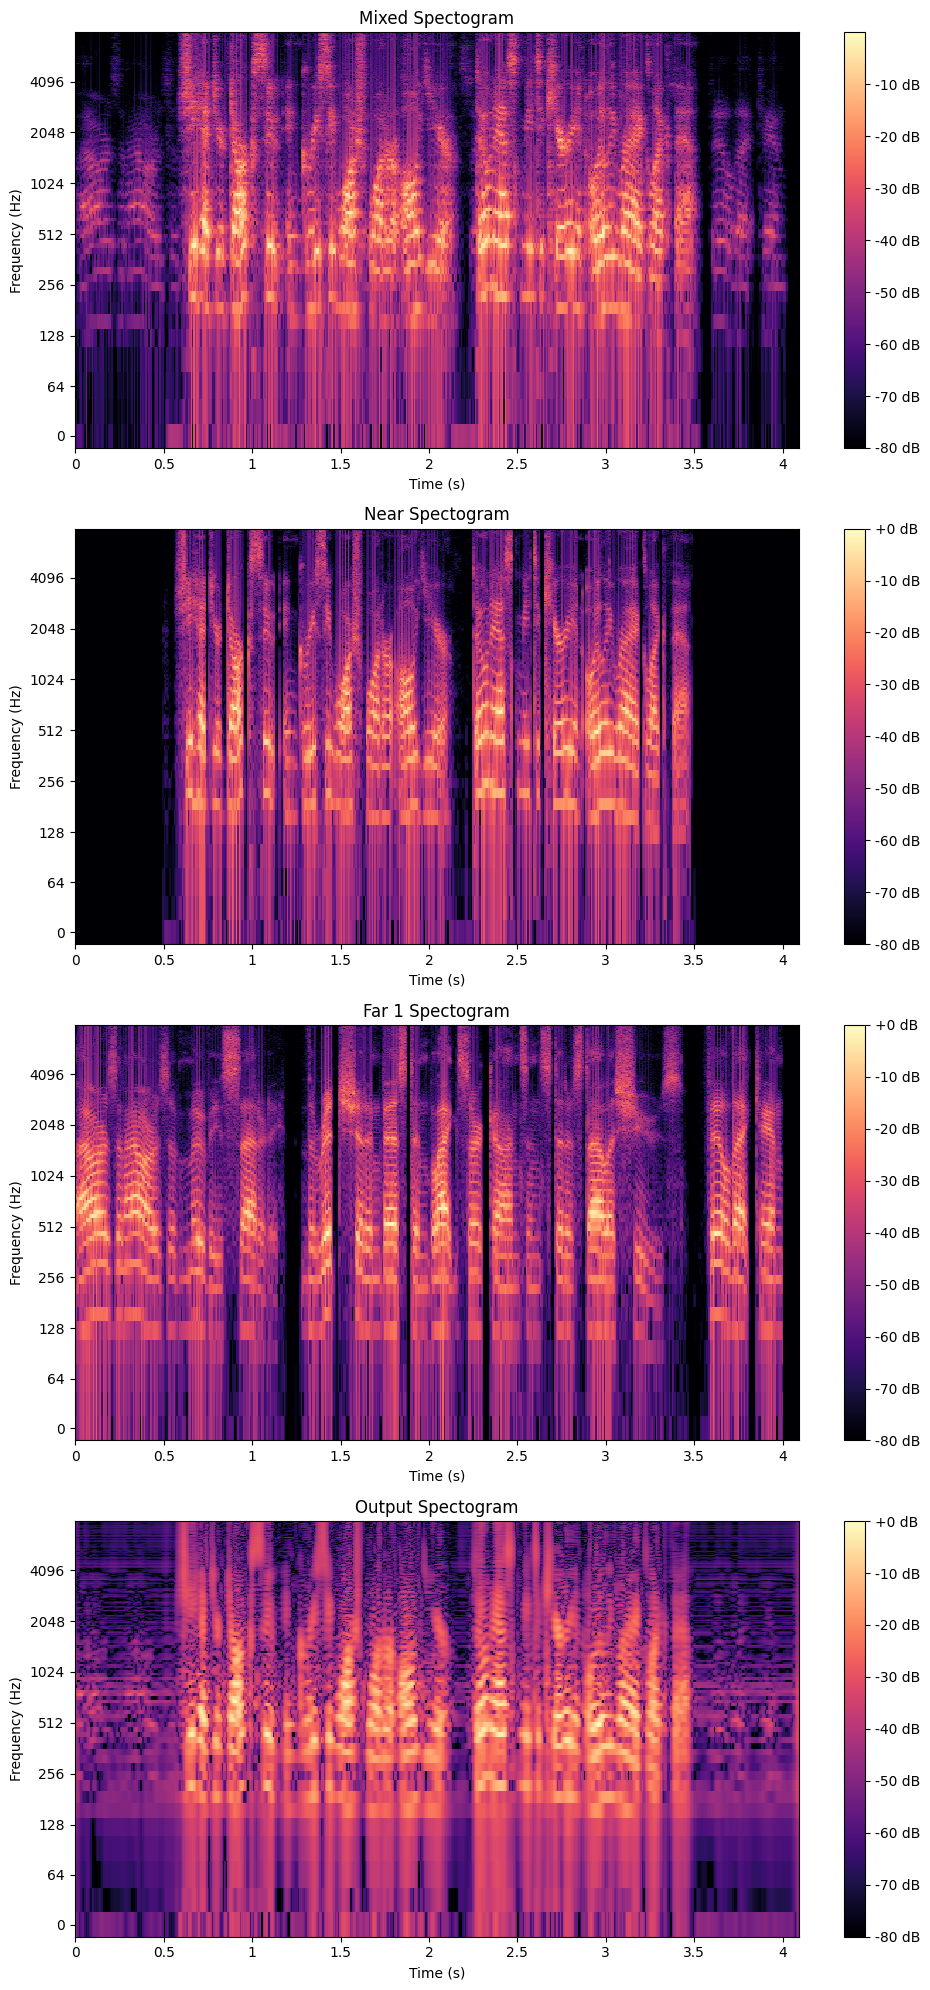

In [6]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

##### CNN 2

In [7]:
class CNN1D(nn.Module):
    def __init__(self, input_channels=771, output_channels=257, kernel_size=5, padding=2, stride=1):
        super(CNN1D, self).__init__()
        self.CNNlayer1 = 600
        self.CNNlayer2 = 771
        self.CNNlayer3 = 450
        self.CNNlayer4 = 300
        
        self.conv1 = nn.Conv1d(input_channels, self.CNNlayer1, kernel_size, stride, padding)
        self.BNorm1 = nn.BatchNorm1d(self.CNNlayer1)
        self.act1 = nn.Tanh()
        self.dropout1 = nn.Dropout(p=0.1)
        self.conv2 = nn.Conv1d(self.CNNlayer1, self.CNNlayer2, kernel_size, stride, padding)
        self.BNorm2 = nn.BatchNorm1d(self.CNNlayer2)
        self.act2 = nn.Tanh()
        self.dropout2 = nn.Dropout(p=0.1)
        self.conv3 = nn.Conv1d(self.CNNlayer2, self.CNNlayer3, kernel_size, stride, padding)
        self.BNorm3 = nn.BatchNorm1d(self.CNNlayer3)
        self.act3 = nn.Tanh()
        self.dropout3 = nn.Dropout(p=0.1)
        self.conv4 = nn.Conv1d(self.CNNlayer3, self.CNNlayer4, kernel_size, stride, padding)
        self.BNorm4 = nn.BatchNorm1d(self.CNNlayer4)
        self.act4 = nn.Tanh()
        self.dropout4 = nn.Dropout(p=0.1)
        self.conv5 = nn.Conv1d(self.CNNlayer4, output_channels, kernel_size, stride, padding)
        self.act5 = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.act1(self.BNorm1(self.conv1(x))))
        x = self.dropout2(self.act2(self.BNorm2(self.conv2(x))))
        x = self.dropout3(self.act3(self.BNorm3(self.conv3(x))))
        x = self.dropout4(self.act4(self.BNorm4(self.conv4(x))))
        x = self.conv5(x)
        return x

In [26]:
batch_size = 64
num_epochs = 30
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
model = CNN1D().to(device)
summary(model, (771, 512))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [257, 512]                --
├─Conv1d: 1-1                            [600, 512]                2,313,600
├─BatchNorm1d: 1-2                       [600, 512]                1,024
├─Tanh: 1-3                              [600, 512]                --
├─Dropout: 1-4                           [600, 512]                --
├─Conv1d: 1-5                            [771, 512]                2,313,771
├─BatchNorm1d: 1-6                       [771, 512]                1,024
├─Tanh: 1-7                              [771, 512]                --
├─Dropout: 1-8                           [771, 512]                --
├─Conv1d: 1-9                            [450, 512]                1,735,200
├─BatchNorm1d: 1-10                      [450, 512]                1,024
├─Tanh: 1-11                             [450, 512]                --
├─Dropout: 1-12                          [450, 512]    

In [28]:
train_CNN(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/30] Train Loss: 0.0187, Duration: 1 minutes 24 seconds, ERLE Score: -4.64, PESQ Score: 1.02
[Epoch   2/30] Train Loss: 0.0123, Duration: 34 seconds, ERLE Score: -5.68, PESQ Score: 1.02
[Epoch   3/30] Train Loss: 0.0102, Duration: 34 seconds, ERLE Score: -5.71, PESQ Score: 1.02
[Epoch   4/30] Train Loss: 0.0102, Duration: 34 seconds, ERLE Score: -1.49, PESQ Score: 1.02
[Epoch   5/30] Train Loss: 0.0072, Duration: 32 seconds, ERLE Score: -3.10, PESQ Score: 1.02
[Epoch   6/30] Train Loss: 0.0080, Duration: 32 seconds, ERLE Score: -1.32, PESQ Score: 1.02
[Epoch   7/30] Train Loss: 0.0059, Duration: 32 seconds, ERLE Score: -1.81, PESQ Score: 1.03
[Epoch   8/30] Train Loss: 0.0077, Duration: 32 seconds, ERLE Score: 1.37, PESQ Score: 1.03
[Epoch   9/30] Train Loss: 0.0075, Duration: 33 seconds, ERLE Score: 3.17, PESQ Score: 1.02
[Epoch  10/30] Train Loss: 0.0043, Duration: 32 seconds, ERLE Score: 0.08, PESQ Score: 1.02
[Epoch  11/30] Train Loss: 0.0076, Duration: 32 seconds, ERLE S

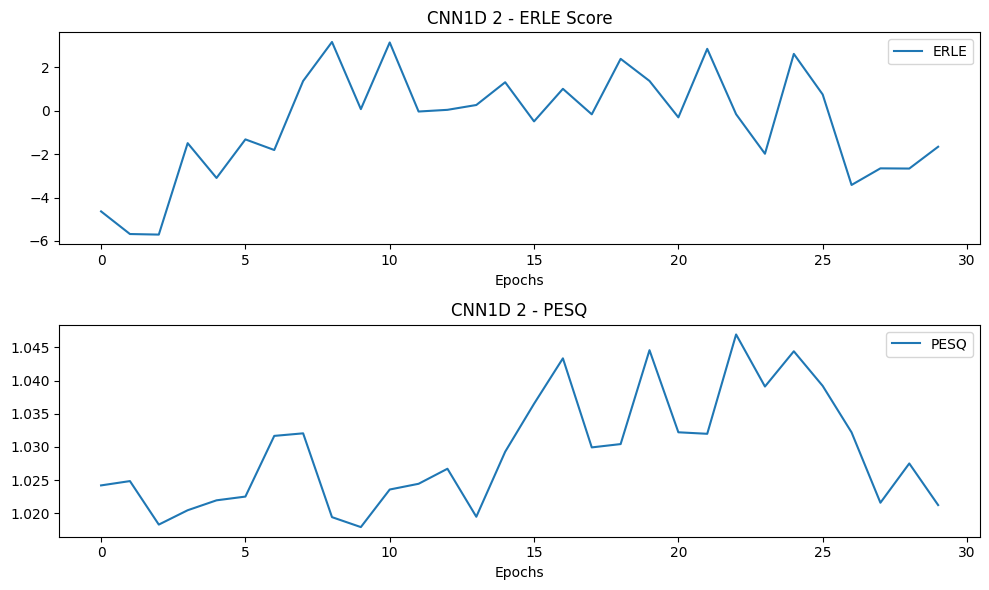

In [29]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("CNN1D 2 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("CNN1D 2 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
torch.save(model, "./models/CNN1D_2.pth")

In [15]:
model = torch.load("./models/CNN1D_2.pth")
model = model.to('cuda') 
model.eval()


CNN1D(
  (conv1): Conv1d(771, 600, kernel_size=(5,), stride=(1,), padding=(2,))
  (BNorm1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): Tanh()
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv1d(600, 771, kernel_size=(5,), stride=(1,), padding=(2,))
  (BNorm2): BatchNorm1d(771, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): Tanh()
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv3): Conv1d(771, 450, kernel_size=(5,), stride=(1,), padding=(2,))
  (BNorm3): BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): Tanh()
  (dropout3): Dropout(p=0.1, inplace=False)
  (conv4): Conv1d(450, 300, kernel_size=(5,), stride=(1,), padding=(2,))
  (BNorm4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act4): Tanh()
  (dropout4): Dropout(p=0.1, inplace=False)
  (conv5): Conv1d(300, 257, kernel_size=(5,), stride=(1,), padding=(2,))
  (act5): Si

In [11]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
axis = 0
combined_input = combined
combined_input.shape

torch.Size([771, 512])

In [ ]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="CNN1D_2", n_fft=512, hop_length=256, sr=16000, write=1)


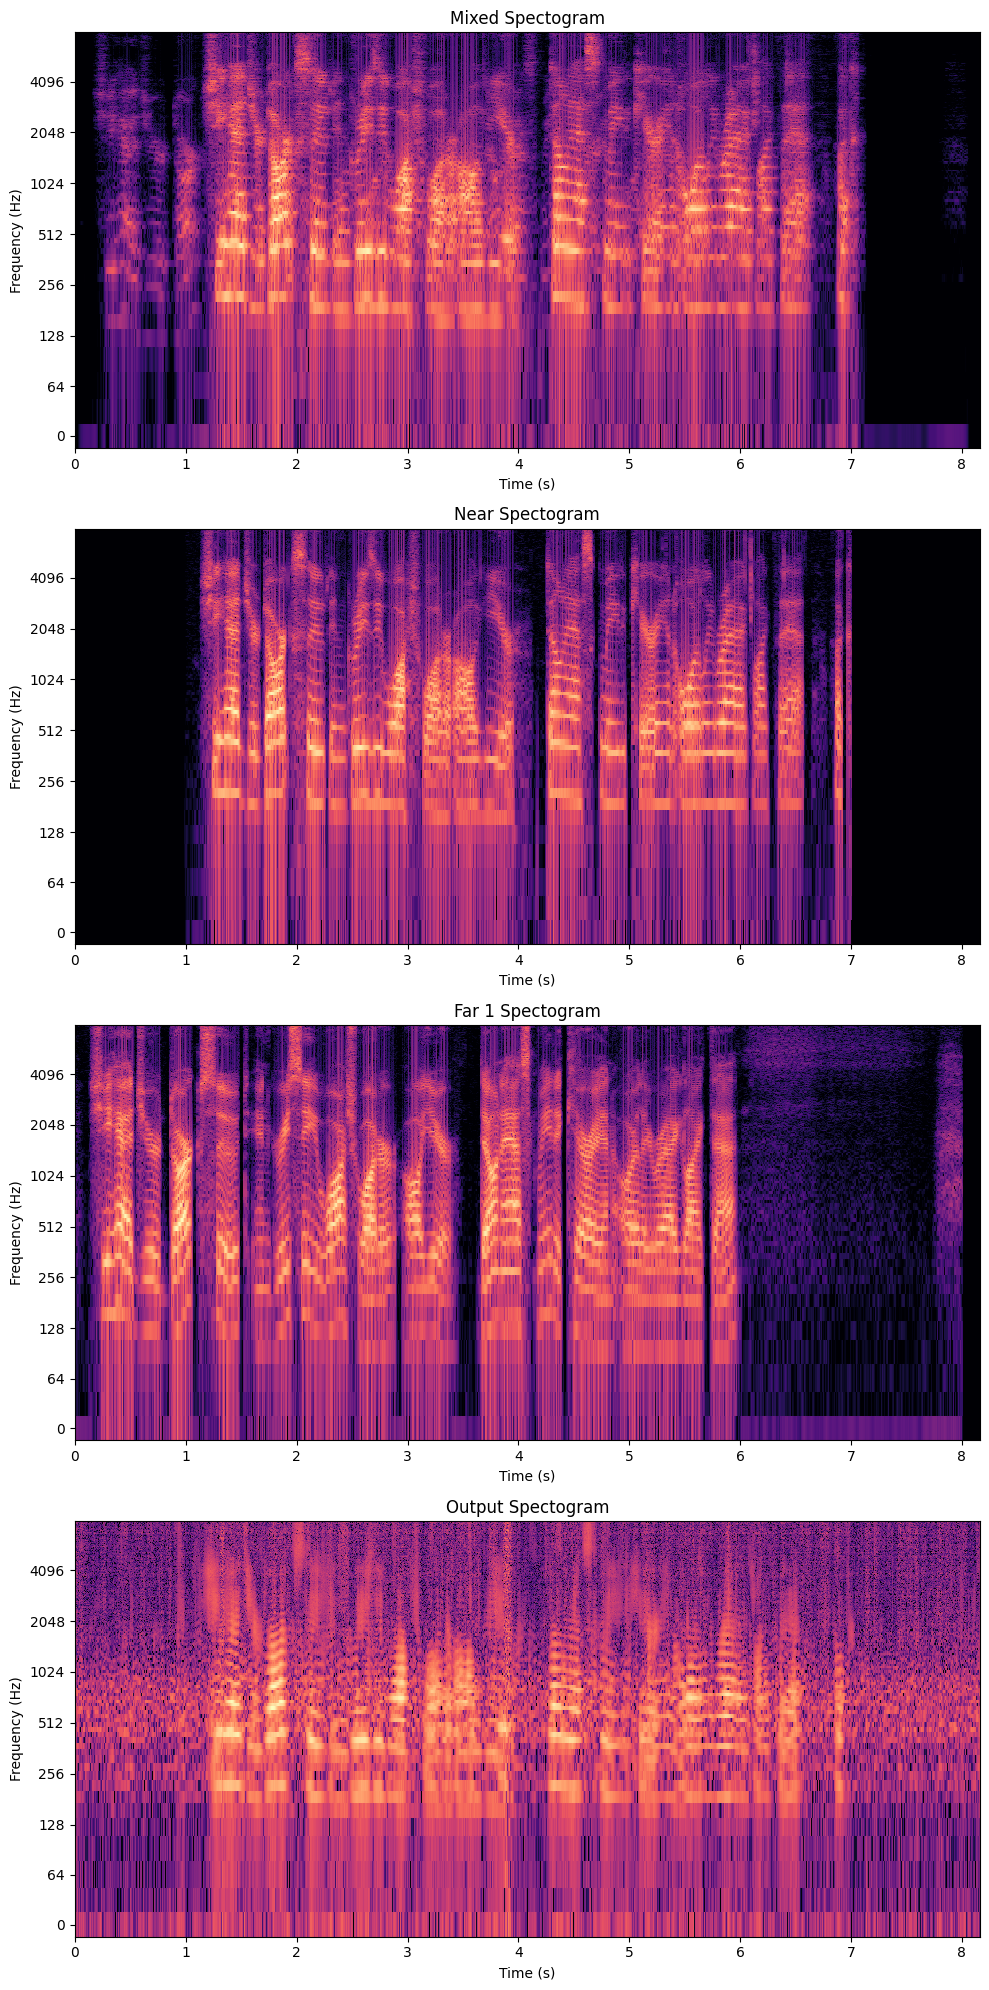

In [24]:
data = [mixed_batch[0], near_batch[0], far1_batch[0], output[0]]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

plot_spectograms(data, titles)

### UNET


In [5]:
def train_UNet(model, train_loader, num_epochs=10, learning_rate=0.001, device="cuda", erle_arr=[], pesq_arr=[], max_frames=512):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0

        for mixed, far1, far2, near, near_phase in train_loader:
            combined_input = torch.cat((far1, far2, mixed), dim=1) # [batch_size, 3*257, 512]
            optimizer.zero_grad()
            
            outputs = model(combined_input)
            loss = criterion(outputs.squeeze(1), near)
            loss.backward()
            optimizer.step()
        
        near_phase = near_phase.cpu().numpy()
        near = near.cpu().numpy()
        outputs = outputs.detach().cpu().squeeze(1).numpy()
        erle_score = functions.compute_erle(near, outputs)
        near_wave = functions.to_wave(near[0], near_phase[0], write=0, filename="near")
        output_wave = functions.to_wave(outputs[0], near_phase[0], write=0, filename="output")
        pesq_score = pesq(16000, near_wave, output_wave)
        erle_arr.append(erle_score)
        pesq_arr.append(pesq_score)
        duration = functions.timeit(start_time)
        print(f"[Epoch {epoch+1:3d}/{num_epochs:2d}] Train Loss: {loss.item():.4f}, Duration: {duration}, ERLE Score: {erle_score:.2f}, PESQ Score: {pesq_score:.2f}")



##### UNET 1

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257):
        super(UNet, self).__init__()

        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, 256)
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(256, 256)
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(256, 256)
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(256, 256)
        self.encoder_pool4 = nn.MaxPool1d(2)

        # Bottleneck 
        self.bottleneck_conv = self._double_conv(256, 512)


        # Decoder (Upsampling path)
        self.decoder_up4 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(512, 256)
        self.decoder_up3 = nn.ConvTranspose1d(256, 256, kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(512, 256)
        self.decoder_up2 = nn.ConvTranspose1d(256, 256, kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(512, 256)
        self.decoder_up1 = nn.ConvTranspose1d(256, 256, kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(512, 256)

        # Output layer
        self.output_conv = nn.Conv1d(256, out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        
        # # Bottleneck
        bottleneck = self.bottleneck_conv(pool4)
        
        # # Decoder with skip connections
        dec4 = self.decoder_up4(bottleneck)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [16]:
batch_size = 64
num_epochs = 30
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
model = UNet().to(device)
torchsummary.summary(model, (771, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 256, 512]         592,384
              ReLU-2             [-1, 256, 512]               0
            Conv1d-3             [-1, 256, 512]         196,864
              ReLU-4             [-1, 256, 512]               0
         MaxPool1d-5             [-1, 256, 256]               0
            Conv1d-6             [-1, 256, 256]         196,864
              ReLU-7             [-1, 256, 256]               0
            Conv1d-8             [-1, 256, 256]         196,864
              ReLU-9             [-1, 256, 256]               0
        MaxPool1d-10             [-1, 256, 128]               0
           Conv1d-11             [-1, 256, 128]         196,864
             ReLU-12             [-1, 256, 128]               0
           Conv1d-13             [-1, 256, 128]         196,864
             ReLU-14             [-1, 2

In [21]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/30] Train Loss: 0.0007, Duration: 1 minutes 18 seconds, ERLE Score: 1.41, PESQ Score: 1.46
[Epoch   2/30] Train Loss: 0.0019, Duration: 27 seconds, ERLE Score: 2.34, PESQ Score: 1.56
[Epoch   3/30] Train Loss: 0.0016, Duration: 27 seconds, ERLE Score: 0.48, PESQ Score: 1.58
[Epoch   4/30] Train Loss: 0.0009, Duration: 27 seconds, ERLE Score: 0.35, PESQ Score: 1.45
[Epoch   5/30] Train Loss: 0.0008, Duration: 27 seconds, ERLE Score: 1.62, PESQ Score: 1.39
[Epoch   6/30] Train Loss: 0.0008, Duration: 27 seconds, ERLE Score: 0.00, PESQ Score: 1.75
[Epoch   7/30] Train Loss: 0.0008, Duration: 27 seconds, ERLE Score: 1.64, PESQ Score: 1.59
[Epoch   8/30] Train Loss: 0.0007, Duration: 27 seconds, ERLE Score: 1.26, PESQ Score: 1.58
[Epoch   9/30] Train Loss: 0.0007, Duration: 27 seconds, ERLE Score: 0.56, PESQ Score: 1.61
[Epoch  10/30] Train Loss: 0.0005, Duration: 27 seconds, ERLE Score: 0.26, PESQ Score: 1.67
[Epoch  11/30] Train Loss: 0.0011, Duration: 27 seconds, ERLE Score: 0

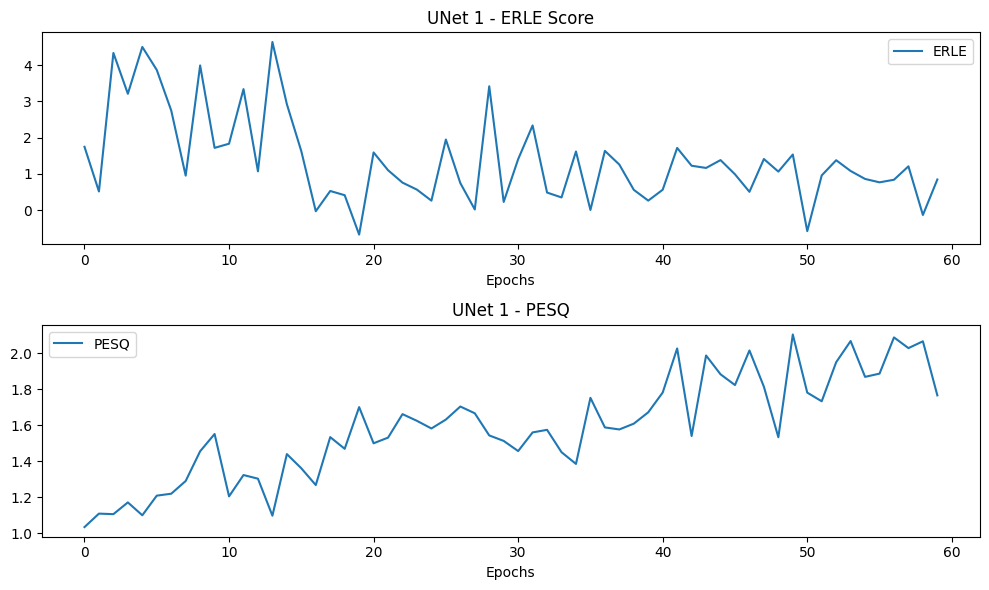

In [22]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet 1 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet 1 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
torch.save(model, "./models/UNET1.pth")

In [17]:
model = torch.load("./models/UNET1.pth")
model = model.to('cuda') 
model.eval()


UNet(
  (encoder_conv1): Sequential(
    (0): Conv1d(771, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder_pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder_pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv3): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder_pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_co

In [21]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
axis = 0
combined_input = combined.unsqueeze(0)
combined_input.shape

torch.Size([1, 771, 512])

In [22]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="UNET_1", n_fft=512, hop_length=256, sr=16000, write=1)


array([ 2.1888916e-06, -4.2380831e-05,  8.6142627e-06, ...,
        2.5413157e-05,  6.3443782e-05,  6.6950073e-05], dtype=float32)

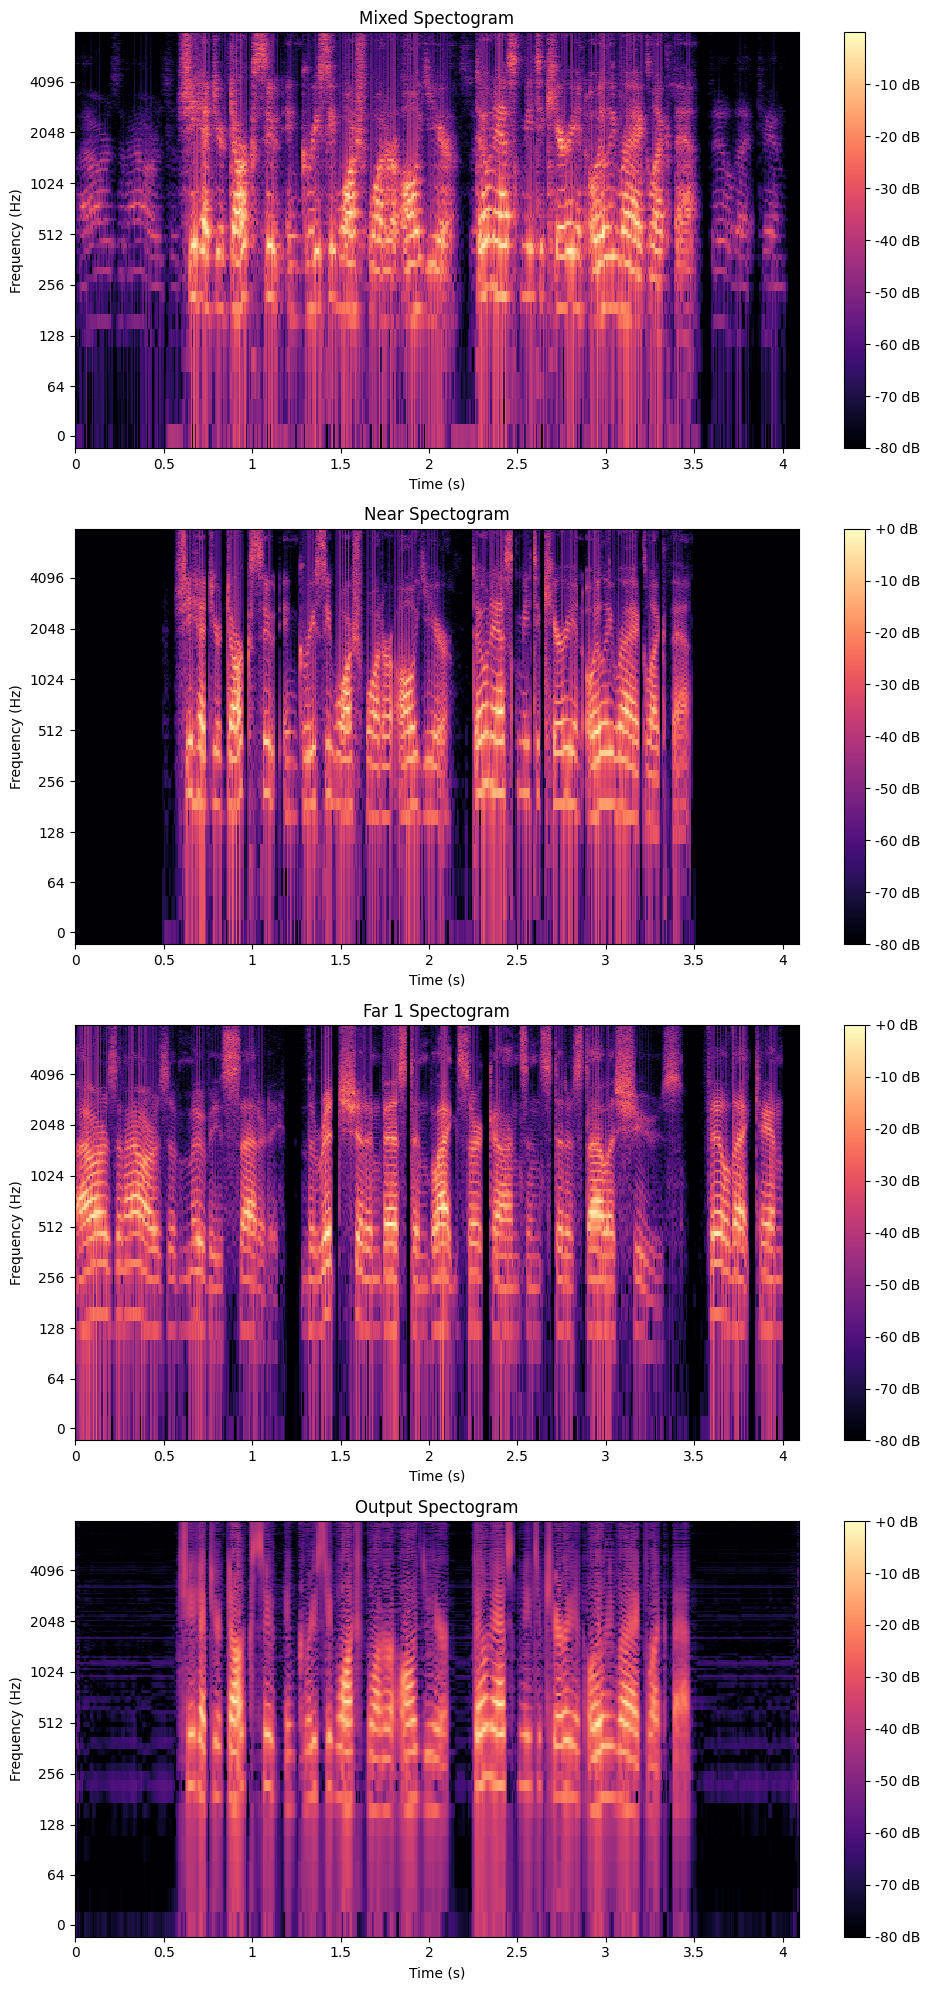

In [23]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

##### UNET 2

In [24]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [512, 768, 1024, 1280]):
        super(UNet, self).__init__()

        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)

        # Bottleneck 
        self.bottleneck_conv = self._double_conv(features[3], features[3]*2)


        # Decoder (Upsampling path)
        self.decoder_up4 = nn.ConvTranspose1d(features[3]*2, features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3]*2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2]*2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1]*2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0]*2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        
        # # Bottleneck
        bottleneck = self.bottleneck_conv(pool4)
        
        # # Decoder with skip connections
        dec4 = self.decoder_up4(bottleneck)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [6]:
batch_size = 128
num_epochs = 30
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = UNet().to(device)
torchsummary.summary(model, (771, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 512, 512]       1,184,768
              ReLU-2             [-1, 512, 512]               0
            Conv1d-3             [-1, 512, 512]         786,944
              ReLU-4             [-1, 512, 512]               0
         MaxPool1d-5             [-1, 512, 256]               0
            Conv1d-6             [-1, 768, 256]       1,180,416
              ReLU-7             [-1, 768, 256]               0
            Conv1d-8             [-1, 768, 256]       1,770,240
              ReLU-9             [-1, 768, 256]               0
        MaxPool1d-10             [-1, 768, 128]               0
           Conv1d-11            [-1, 1024, 128]       2,360,320
             ReLU-12            [-1, 1024, 128]               0
           Conv1d-13            [-1, 1024, 128]       3,146,752
             ReLU-14            [-1, 10

In [11]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/30] Train Loss: 0.0017, Duration: 36 seconds, ERLE Score: 1.96, PESQ Score: 1.39
[Epoch   2/30] Train Loss: 0.0014, Duration: 36 seconds, ERLE Score: 1.23, PESQ Score: 1.46
[Epoch   3/30] Train Loss: 0.0011, Duration: 36 seconds, ERLE Score: 1.07, PESQ Score: 1.60
[Epoch   4/30] Train Loss: 0.0011, Duration: 35 seconds, ERLE Score: 0.37, PESQ Score: 1.50
[Epoch   5/30] Train Loss: 0.0010, Duration: 35 seconds, ERLE Score: 0.61, PESQ Score: 1.83
[Epoch   6/30] Train Loss: 0.0009, Duration: 35 seconds, ERLE Score: 1.11, PESQ Score: 1.66
[Epoch   7/30] Train Loss: 0.0011, Duration: 36 seconds, ERLE Score: 0.62, PESQ Score: 1.68
[Epoch   8/30] Train Loss: 0.0012, Duration: 35 seconds, ERLE Score: 1.45, PESQ Score: 1.82
[Epoch   9/30] Train Loss: 0.0012, Duration: 35 seconds, ERLE Score: 1.90, PESQ Score: 1.58
[Epoch  10/30] Train Loss: 0.0011, Duration: 36 seconds, ERLE Score: 1.43, PESQ Score: 1.93
[Epoch  11/30] Train Loss: 0.0011, Duration: 35 seconds, ERLE Score: 1.22, PESQ 

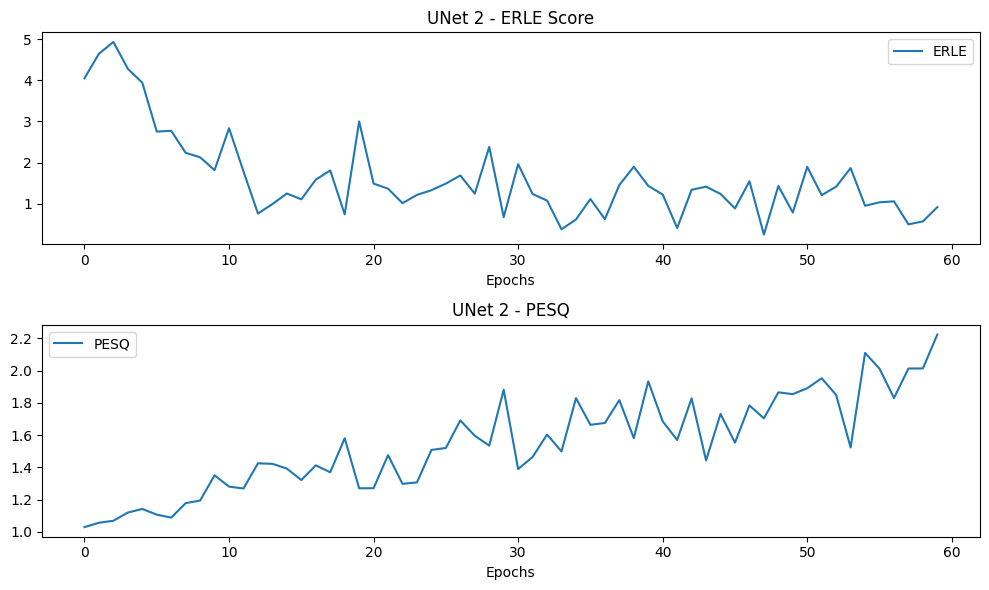

In [12]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet 2 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet 2 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
torch.save(model, "./models/UNET2.pth")

In [25]:
model = torch.load("./models/UNET2.pth")
model = model.to('cuda') 
model.eval()


UNet(
  (encoder_conv1): Sequential(
    (0): Conv1d(771, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder_pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Sequential(
    (0): Conv1d(512, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder_pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv3): Sequential(
    (0): Conv1d(768, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder_pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder

In [26]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
axis = 0
combined_input = combined.unsqueeze(0)
combined_input.shape

torch.Size([1, 771, 512])

In [28]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="UNET_2", n_fft=512, hop_length=256, sr=16000, write=1)


array([-2.6826696e-05,  1.7737392e-06, -5.7877110e-06, ...,
        3.4942710e-05,  2.2332073e-05,  1.8842687e-05], dtype=float32)

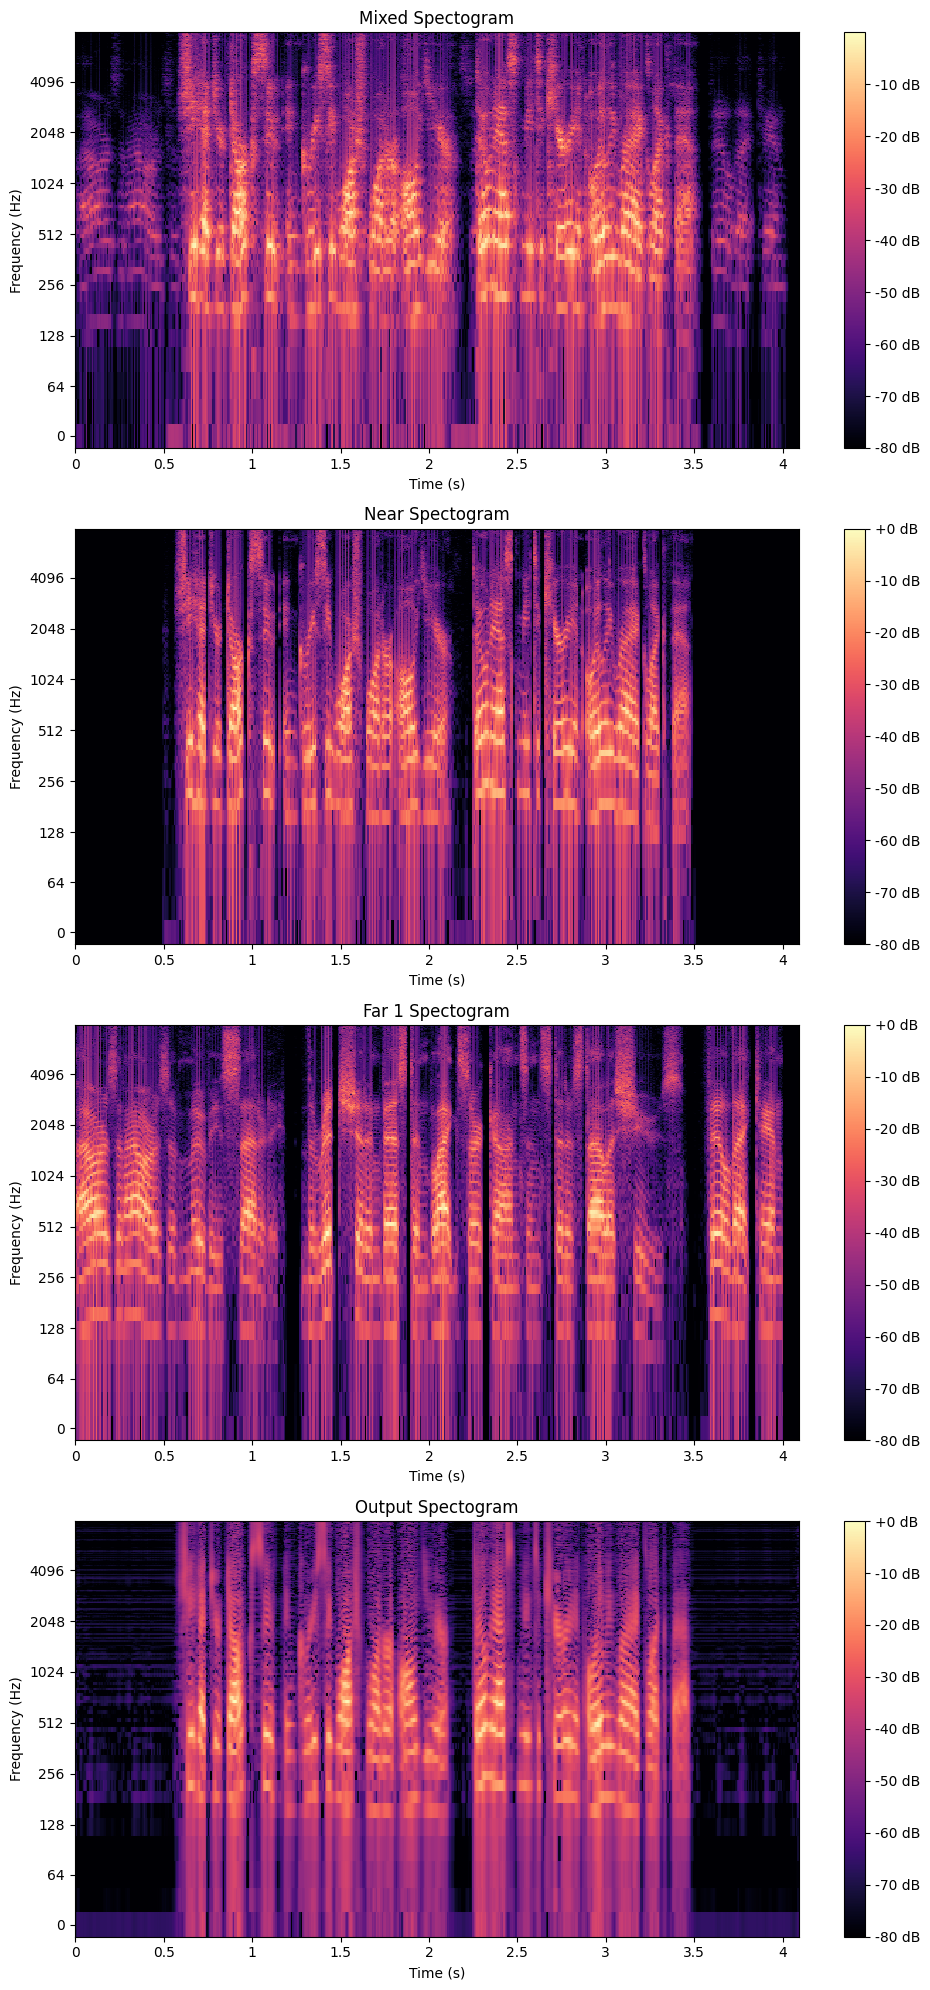

In [29]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

##### UNET 3 + Attention

In [30]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv1d(F_g, F_int, kernel_size=1, padding=0, bias=True),
            nn.BatchNorm1d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv1d(F_l, F_int, kernel_size=1, padding=0, bias=True),
            nn.BatchNorm1d(F_int)
        )
        self.psi = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(F_int, 1, kernel_size=1, padding=0, bias=True),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(self.relu(g1 + x1))
        return x * psi

class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [512, 768, 1024, 1280]):
        super(UNet, self).__init__()

        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)

        # Bottleneck
        self.bottleneck_conv = self._double_conv(features[3], features[3]*2)


        # Decoder (Upsampling path)
        self.decoder_up4 = nn.ConvTranspose1d(features[3]*2, features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3]*2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2]*2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1]*2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0]*2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(512, out_channels, kernel_size=1) # 1x1 convolution

        # Attention blocks
        self.attn4 = AttentionBlock(features[3], features[3], features[3]//2) #attention block for dec4
        self.attn3 = AttentionBlock(features[2], features[2], features[2]//2) #attention block for dec3
        self.attn2 = AttentionBlock(features[1], features[1], features[1]//2) #attention block for dec2
        self.attn1 = AttentionBlock(features[0], features[0], features[0]//2) #attention block for dec1

    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        
        # # Bottleneck
        bottleneck = self.bottleneck_conv(pool4)
        
        # # Decoder with skip connections
        dec4 = self.decoder_up4(bottleneck)
        attn4 = self.attn4(dec4, enc4) # apply attention before skip connection
        dec4 = self.decoder_conv4(torch.cat([dec4, attn4], dim=1)) # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        attn3 = self.attn3(dec3, enc3)
        dec3 = self.decoder_conv3(torch.cat([dec3, attn3], dim=1))
        dec2 = self.decoder_up2(dec3)
        attn2 = self.attn2(dec2, enc2)
        dec2 = self.decoder_conv2(torch.cat([dec2, attn2], dim=1))
        dec1 = self.decoder_up1(dec2)
        attn1 = self.attn1(dec1, enc1)
        dec1 = self.decoder_conv1(torch.cat([dec1, attn1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [6]:
batch_size = 128
num_epochs = 30
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = UNet().to(device)
torchsummary.summary(model, (771, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 512, 512]       1,184,768
              ReLU-2             [-1, 512, 512]               0
            Conv1d-3             [-1, 512, 512]         786,944
              ReLU-4             [-1, 512, 512]               0
         MaxPool1d-5             [-1, 512, 256]               0
            Conv1d-6             [-1, 768, 256]       1,180,416
              ReLU-7             [-1, 768, 256]               0
            Conv1d-8             [-1, 768, 256]       1,770,240
              ReLU-9             [-1, 768, 256]               0
        MaxPool1d-10             [-1, 768, 128]               0
           Conv1d-11            [-1, 1024, 128]       2,360,320
             ReLU-12            [-1, 1024, 128]               0
           Conv1d-13            [-1, 1024, 128]       3,146,752
             ReLU-14            [-1, 10

In [8]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/30] Train Loss: 0.0036, Duration: 2 minutes 3 seconds, ERLE Score: 3.55, PESQ Score: 1.03
[Epoch   2/30] Train Loss: 0.0033, Duration: 1 minutes 54 seconds, ERLE Score: 4.88, PESQ Score: 1.05
[Epoch   3/30] Train Loss: 0.0031, Duration: 1 minutes 58 seconds, ERLE Score: 4.75, PESQ Score: 1.04
[Epoch   4/30] Train Loss: 0.0028, Duration: 1 minutes 50 seconds, ERLE Score: 3.82, PESQ Score: 1.07
[Epoch   5/30] Train Loss: 0.0027, Duration: 1 minutes 51 seconds, ERLE Score: 2.52, PESQ Score: 1.07
[Epoch   6/30] Train Loss: 0.0022, Duration: 1 minutes 52 seconds, ERLE Score: 1.89, PESQ Score: 1.08
[Epoch   7/30] Train Loss: 0.0019, Duration: 1 minutes 51 seconds, ERLE Score: 3.53, PESQ Score: 1.22
[Epoch   8/30] Train Loss: 0.0021, Duration: 1 minutes 51 seconds, ERLE Score: 2.62, PESQ Score: 1.15
[Epoch   9/30] Train Loss: 0.0018, Duration: 1 minutes 51 seconds, ERLE Score: 1.48, PESQ Score: 1.12
[Epoch  10/30] Train Loss: 0.0021, Duration: 1 minutes 51 seconds, ERLE Score: 1.02

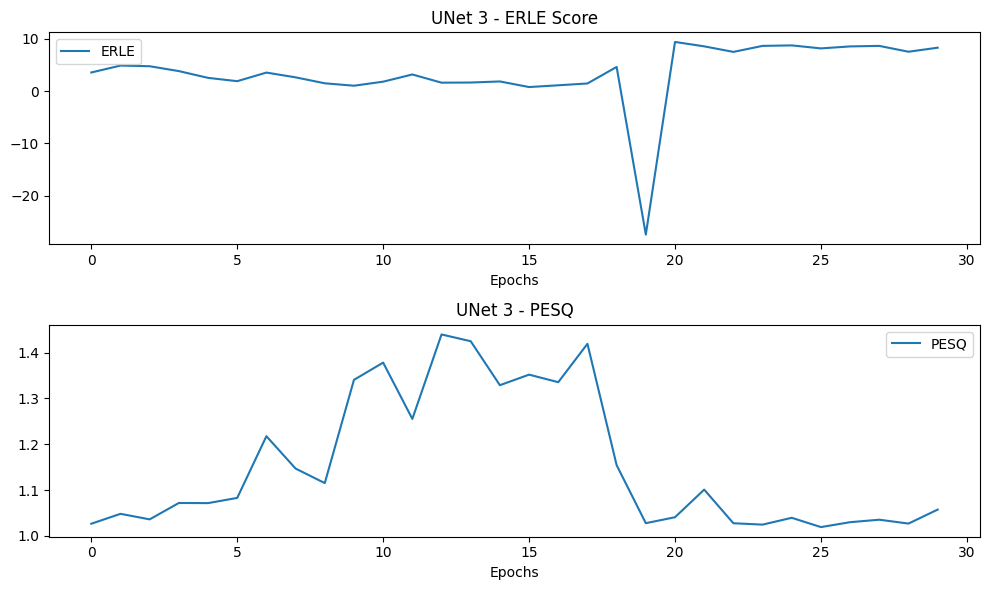

In [9]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet 3 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet 3 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
torch.save(model, "./models/UNET3.pth")

In [31]:
model = torch.load("./models/UNET3.pth")
model = model.to('cuda') 
model.eval()


UNet(
  (encoder_conv1): Sequential(
    (0): Conv1d(771, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder_pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Sequential(
    (0): Conv1d(512, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder_pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv3): Sequential(
    (0): Conv1d(768, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder_pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder

In [32]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
axis = 0
combined_input = combined.unsqueeze(0)
combined_input.shape

torch.Size([1, 771, 512])

In [33]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="UNET_3", n_fft=512, hop_length=256, sr=16000, write=1)


array([ 0.00134488, -0.00057135,  0.00020609, ...,  0.00079551,
        0.00020609, -0.00057135], dtype=float32)

In [34]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)